In [21]:
# imports
import requests
import json
import pandas as pd
import os

# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [6]:
# connect to foursquare api

def fs_api_request(ll,radius,categories,fields):
    fs_url = 'https://api.foursquare.com/v3/places/search' 
    key = os.environ.get('FOURSQUARE_API_KEY')
    fs_headers = {"authorization": f'{key}',"accept": "application/json"}
    fs_params = {
        "ll": ll,
        "radius": radius,
        "categories": categories,
        "fields": fields,
    }
    fs_response = requests.get(fs_url, headers=fs_headers, params=fs_params)
    fs_data = fs_response.json()

    return fs_data

bike_df = pd.read_csv('bike_stations.csv') # read bike stations csv

for index,row in bike_df.iterrows():
    ll = f"{row['latitude']},{row['longitude']}"
    results = fs_api_request(ll,radius=1000,categories=None,fields=None)
print(results['results'][0]['location']['formatted_address'])

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [ ]:
for index,row in bike_df.iterrows():
    ll = f"{row['latitude']},{row['longitude']}"
    results = fs_api_request(ll,radius=1000,categories=None,fields=None)

    venue_name = results['results'][0]['categories'][0]['name']
    venue_location = results['results'][0]['location']['formatted_address']

    print(f'name = {venue_name}, location = {venue_location}')

Put your parsed results into a DataFrame

In [ ]:
# create dataframe to store venue data
fs_venue_df = pd.DataFrame()

for index,row in bike_df.iterrows():
    ll = f"{row['latitude']},{row['longitude']}"
    results = fs_api_request(ll,radius=1000,categories=13065,fields=None) # 13065 = restaurant
    norm_results = pd.json_normalize(results)
    norm_results['station_id'] = row['id'] # add station id to dataframe

    fs_venue_df = pd.concat([fs_venue_df,norm_results], ignore_index=True)

fs_venue_df

In [ ]:
fs_venue_df.to_csv('fs_venue_df.csv', index=False) # save dataframe to csv
fs_venue_df

In [ ]:
fs_venue = pd.read_csv('fs_venue_df.csv') # read csv

normalized_results_column = pd.json_normalize(fs_venue['results'])
fs_venue['distance'] = normalized_results_column['distance']

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [ ]:
# connect to yelp api

def yelp_api_request(latitude,longitude,radius,categories):
    key = os.environ.get('YELP_API_KEY')
    yelp_url = "https://api.yelp.com/v3/businesses/search"
    yelp_headers = {"authorization":f"Bearer {key}","accept": "application/json"}
    yelp_params = {
        "latitude": latitude,
        "longitude": longitude,
        "radius": radius,
        "categories": categories,
        "limit": 10
        }
    yelp_response = requests.get(yelp_url, headers=yelp_headers, params=yelp_params)
    yelp_data = yelp_response.json()

    if 'businesses' in yelp_data:
        return yelp_data['businesses']
    else:
        print(f"Error: {yelp_data}")
        return []

# read bike stations csv
bike_df = pd.read_csv('bike_stations.csv')

for index,row in bike_df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    results = yelp_api_request(latitude,longitude,radius=1000,categories=None)
    print(results)

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [ ]:
for index,row in bike_df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    results = yelp_api_request(latitude,longitude,radius=1000,categories='restaurants')

    venue_name = results[0]['name']
    venue_location = results[0]['location']

    print(f'name = {venue_name}, location = {venue_location}')

Put your parsed results into a DataFrame

In [26]:
# create dataframe to store venue data
yelp_venue_df = pd.DataFrame()

for index,row in bike_df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']

    results = yelp_api_request(latitude,longitude,radius=1000,categories='restaurants')
    norm_results = pd.json_normalize(results)
    norm_results['station_id'] = row['id'] # add station id to dataframe

    yelp_venue_df = pd.concat([yelp_venue_df,norm_results], ignore_index=True)

yelp_venue_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,station_id
0,6iOAgzJ0DRZNSKA3FSrrOg,la-taqueria-pinche-taco-shop-vancouver,La Taqueria Pinche Taco Shop,https://s3-media1.fl.yelpcdn.com/bphoto/fjhIj3...,False,https://www.yelp.com/biz/la-taqueria-pinche-ta...,685,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.0,[],...,-123.112736,2450 Yukon Street,,,Vancouver,V5Z 3V6,CA,BC,"[2450 Yukon Street, Vancouver, BC V5Z 3V6, Can...",7a19c49f486d7c0c02b3685d7b240448
1,XAH2HpuUUtu7CUO26pbs4w,saku-vancouver-8,Saku,https://s3-media1.fl.yelpcdn.com/bphoto/mKOSej...,False,https://www.yelp.com/biz/saku-vancouver-8?adju...,237,"[{'alias': 'japanese', 'title': 'Japanese'}]",4.5,[],...,-123.116675,548 W Broadway,,None,Vancouver,V5Z 1E9,CA,BC,"[548 W Broadway, Vancouver, BC V5Z 1E9, Canada]",7a19c49f486d7c0c02b3685d7b240448
2,nkDZY5xqihF3XtZMzzfqqg,hokkaido-ramen-santouka-vancouver-5,Hokkaido Ramen Santouka,https://s3-media2.fl.yelpcdn.com/bphoto/9Fe-Lq...,False,https://www.yelp.com/biz/hokkaido-ramen-santou...,226,"[{'alias': 'noodles', 'title': 'Noodles'}, {'a...",4.0,[],...,-123.116892,558 W Broadway,,None,Vancouver,V5Z 1E9,CA,BC,"[558 W Broadway, Vancouver, BC V5Z 1E9, Canada]",7a19c49f486d7c0c02b3685d7b240448
3,4118Aq9LbkvUr4s719uUkA,uma-sushi-vancouver,Uma Sushi,https://s3-media4.fl.yelpcdn.com/bphoto/gE3vdj...,False,https://www.yelp.com/biz/uma-sushi-vancouver?a...,117,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.5,[],...,-123.113729,450 W 8th Avenue,,None,Vancouver,V5Y 1N9,CA,BC,"[450 W 8th Avenue, Vancouver, BC V5Y 1N9, Canada]",7a19c49f486d7c0c02b3685d7b240448
4,NensKn1MSVU_rm-1Y6WlFA,marulilu-cafe-vancouver,Marulilu Cafe,https://s3-media2.fl.yelpcdn.com/bphoto/uwwarf...,False,https://www.yelp.com/biz/marulilu-cafe-vancouv...,288,"[{'alias': 'cafes', 'title': 'Cafes'}]",4.0,[],...,-123.114150,451 W Broadway,,,Vancouver,V5Y 1R4,CA,BC,"[451 W Broadway, Vancouver, BC V5Y 1R4, Canada]",7a19c49f486d7c0c02b3685d7b240448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,crM1idgY_glhtxXT5kERNg,kingyo-vancouver,Kingyo,https://s3-media1.fl.yelpcdn.com/bphoto/A33fW_...,False,https://www.yelp.com/biz/kingyo-vancouver?adju...,1104,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.5,[],...,-123.137050,871 Denman Street,,,Vancouver,V6G 2L9,CA,BC,"[871 Denman Street, Vancouver, BC V6G 2L9, Can...",3dae5d936bb6b222d135eff52833e7f4
2460,GmEeIcJ9vR04kxzYgPMEgg,guu-with-garlic-vancouver-2,Guu with Garlic,https://s3-media1.fl.yelpcdn.com/bphoto/nmwRtl...,False,https://www.yelp.com/biz/guu-with-garlic-vanco...,1059,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.5,[],...,-123.133814,1698 Robson Street,,,Vancouver,V6G 1C7,CA,BC,"[1698 Robson Street, Vancouver, BC V6G 1C7, Ca...",3dae5d936bb6b222d135eff52833e7f4
2461,wzdPbAjz6UmfN2KRxD0LBg,disco-cheetah-vancouver-5,Disco Cheetah,https://s3-media3.fl.yelpcdn.com/bphoto/Sow9R3...,False,https://www.yelp.com/biz/disco-cheetah-vancouv...,60,"[{'alias': 'korean', 'title': 'Korean'}]",4.0,[],...,-123.132875,1183 Davie Street,,None,Vancouver,V6E 1N2,CA,BC,"[1183 Davie Street, Vancouver, BC V6E 1N2, Can...",3dae5d936bb6b222d135eff52833e7f4
2462,67zb4FcsSKuRMJG3x8qEqQ,cazba-vancouver,Cazba,https://s3-media2.fl.yelpcdn.com/bphoto/zPuhlK...,False,https://www.yelp.com/biz/cazba-vancouver?adjus...,245,"[{'alias': 'persian', 'title': 'Persian/Irania...",3.5,[],...,-123.131271,1103 Davie Street,,,Vancouver,V6E 1N1,CA,BC,"[1103 Davie Street, Vancouver, BC V6E 1N1, Can...",3dae5d936bb6b222d135eff52833e7f4


In [27]:
# save yepl venue dataframe to csv to avoid maxxing out api calls
yelp_venue_df.to_csv('yelp_venue_df.csv', index=False)

In [30]:
yelp_venues = pd.read_csv('yelp_venue_df.csv')

# Select and rename columns from csv to create new dataframe
new_yelp_df = yelp_venues[['name', 'rating', 'coordinates.longitude', 'coordinates.latitude', 'location.address1','location.zip_code','station_id']].rename(columns={
    'name': 'Name',
    'rating': 'Rating',
    'coordinates.longitude': 'Longitude',
    'coordinates.latitude': 'Latitude',
    'location.address1': 'Address',
    'location.zip_code': 'Zipcode',
    'station_id': 'station_id'
})

new_yelp_df

# save new yelp dataframe to csv
new_yelp_df.to_csv('new_yelp_df.csv', index=False)

# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

I believe yelp provided me with more complete data, it had a lot more fields available for you to use to decide what information you wanted to include. It was also a cleaner data set to work with. Yelp gave me more options on what information I could extract for the restaurants around the stations. Additionally, Yelp provided me with more POIs (2463) compared to foursquare (247).

Get the top 10 restaurants according to their rating

In [ ]:
# read csv
import pandas as pd
new_yelp_df = pd.read_csv('new_yelp_df.csv')
new_yelp_df.sort_values(by=['Rating'], ascending=False).head(10)

In [ ]:
# remove nulls
new_yelp_df.dropna(inplace=True)
new_yelp_df.sort_values(by=['Rating'], ascending=False).head(10)

# remove duplicates
new_yelp_df.drop_duplicates(subset='Name', inplace=True)
new_yelp_df.sort_values(by=['Rating'], ascending=False).head(10)

In [ ]:
# compare ratings to the address 
new_yelp_df.sort_values(by=['Rating','Zipcode'], ascending=False).head(15)

In [50]:
# take only first 3 digits of zipcode
zip_area = new_yelp_df['Zipcode'].astype(str).str[:3]
zip_area

# add zip area to dataframe
new_yelp_df['Area'] = zip_area
new_yelp_df

,Name,Rating,Longitude,Latitude,Address,Zipcode,station_id,Area
0,La Taqueria Pinche Taco Shop,4.0,-123.112736,49.263559,2450 Yukon Street,V5Z,7a19c49f486d7c0c02b3685d7b240448,V5Z
1,Saku,4.5,-123.116675,49.263101,548 W Broadway,V5Z,7a19c49f486d7c0c02b3685d7b240448,V5Z
2,Hokkaido Ramen Santouka,4.0,-123.116892,49.263127,558 W Broadway,V5Z,7a19c49f486d7c0c02b3685d7b240448,V5Z
3,Uma Sushi,4.5,-123.113729,49.263805,450 W 8th Avenue,V5Y,7a19c49f486d7c0c02b3685d7b240448,V5Y
4,Marulilu Cafe,4.0,-123.114150,49.263380,451 W Broadway,V5Y,7a19c49f486d7c0c02b3685d7b240448,V5Y
...,...,...,...,...,...,...,...,...
2433,Nori Bento & Udon,3.0,-123.247694,49.266214,6055 University Blvd,V6T,5726de7c5646b82f7aaeafba50aee03e,V6T
2435,Doughgirls,4.5,-123.235875,49.254644,3322 Shrum Lane,V6S,cde61c70e5556ee2fe3ceb9d958b6482,V6S
2436,The Original Beanery,4.0,-123.240132,49.263541,2706 Fairview Crescent,V6T,cde61c70e5556ee2fe3ceb9d958b6482,V6T
2439,Cafe Perugia,3.0,-123.246039,49.262370,2350 Health Sciences Mall,V6T,cde61c70e5556ee2fe3ceb9d958b6482,V6T


In [ ]:
# sort by rating and area
new_yelp_df.sort_values(by=['Rating','Area'], ascending=False).head(15)

<Axes: xlabel='Area'>

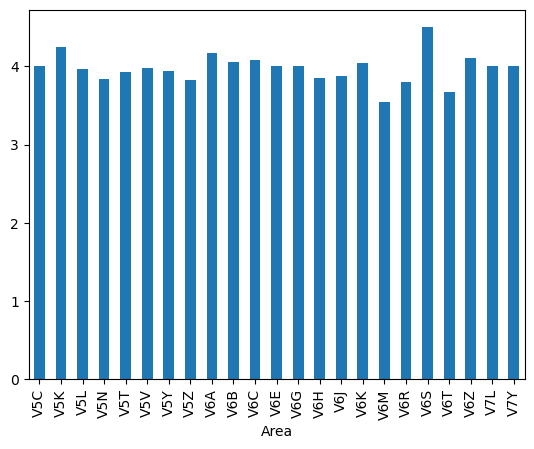

In [53]:
# create bar graph showing ratings by area
new_yelp_df.groupby('Area')['Rating'].mean().plot(kind='bar')